# Exploratory Notebook

## Visualize 3D Volumetric Data

In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug  8 15:04:01 2020

@author: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data#Plotting
Other visualization sources:
    https://plotly.com/python/3d-volume-plots/
    https://plotly.com/python/visualizing-mri-volume-slices/
    http://hyperspy.org/hyperspy-doc/current/user_guide/intro.html
"""

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)
    plt.show()

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# struct_arr = io.imread("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/attention-mri.tif")
# multi_slice_viewer(struct_arr.T)

## Preprocess Embryo Data

### Visualization functions

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 12 10:16:38 2020

@author: hgdsh
"""

from scipy.ndimage import correlate

def normalize_img(a):
    # normalize each channel of 2D/3D image to [0,1]
    temp = a - np.min(a)
    if np.max(temp) != 0:
        b = temp/np.max(temp)
    else:
        b = temp
    return b

def visualize(images, masks, titles):
    """PLot images in one row and masks in one row."""
    num_img = len(images)
    fig, axes = plt.subplots(2, num_img, figsize=(16, 5), sharex=True, sharey=True)
    ax = axes.ravel()
    for k in range(num_img):
        ax[k].imshow(normalize_img(np.squeeze(images[k,:,:,])))
        ax[k].axis('off')
        ax[k].set_title(titles[k]+' bf image')

        ax[k+num_img].imshow(normalize_img(np.squeeze(masks[k,:,:])))
        ax[k+num_img].axis('off')
        ax[k+num_img].set_title(titles[k]+' fluo. image')
    plt.show()

def bf_fluo_correlate(embryo_idx, bf_image, fluo_image, normalized=False, smoothed=False, dim=3):
    """Plot correlation between bf/fluo images, pixel-by-pixel or smoothed in tiles."""
    if normalized:
        bf_image = normalize_img(bf_image)
        fluo_image = normalize_img(fluo_image)
    if smoothed:
        weights = [[1/(dim**2)]*dim]*dim
        bf_image = correlate(bf_image, weights)
        fluo_image = correlate(fluo_image, weights)
    bf_image_flat = bf_image.flatten()
    fluo_image_flat = fluo_image.flatten()
    thresh = np.mean(fluo_image_flat) + np.std(fluo_image_flat)
    plt.scatter(bf_image_flat[fluo_image_flat > thresh], fluo_image_flat[fluo_image_flat > thresh])
    norm_str = ('N' if normalized else 'Unn') + 'ormalized'
    smooth_str = ('' if smoothed else 'un') + 'smoothed'
    plt.xlabel(f"{norm_str} bf frame val")
    plt.ylabel(f"{norm_str} fluo frame val")
    plt.title(f"Correlation plot for {smooth_str} embryo {embryo_idx}")
    plt.show()

# TODO: look into  signal correlate2d... from scipy import signal
# signal.correlate2d(bf_image,fluo_image)

### Define data path

In [14]:
# Specify whether to use a OneDrive path or the local data/ folder
onedrive_data = False

# read a set of embryo data
if onedrive_data:
    bf_data_path = 'D:/New_OneDrive/OneDrive - California Institute of Technology/7. AI Embryo/4. Data/video_bf_data'
    fluo_data_path = 'D:/New_OneDrive/OneDrive - California Institute of Technology/7. AI Embryo/4. Data/video_fluo_data'
else:
    bf_data_path = '../data/video_bf_data'
    fluo_data_path = '../data/video_fluo_data'

### Load h5py files

In [15]:
embryo_idx = 1

bf = h5py.File(os.path.join(bf_data_path,'embryo_'+str(embryo_idx)+'.mat'))
arrays = {}
for k, v in bf.items():
    arrays[k] = np.array(v)
bf_video = arrays['data']
pol_state = arrays['anno']

fluo = h5py.File(os.path.join(fluo_data_path,'embryo_'+str(embryo_idx)+'.mat'))
arrays = {}
for k, v in fluo.items():
    arrays[k] = np.array(v)
fluo_video = arrays['data']
pol_state = arrays['anno']

<ipython-input-15-77a75fff5212>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  bf = h5py.File(os.path.join(bf_data_path,'embryo_'+str(embryo_idx)+'.mat'))
<ipython-input-15-77a75fff5212>:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  fluo = h5py.File(os.path.join(fluo_data_path,'embryo_'+str(embryo_idx)+'.mat'))


## Volumentric visualization of embryos

In embryo 1, 16 nonpolarized frames and 5 polarized frames


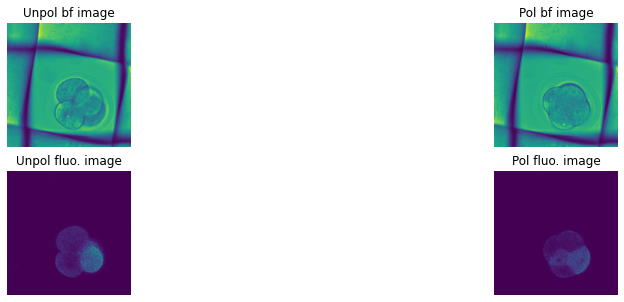

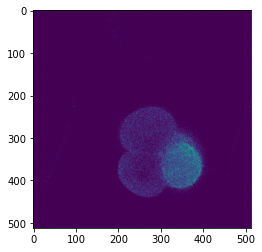

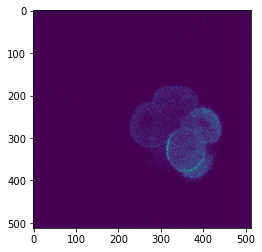

In [16]:
# vis polarized vs unpolarized
num_nonpol = np.sum(pol_state==0)
num_pol = np.sum(pol_state==1)
print('In embryo %d, %d nonpolarized frames and %d polarized frames' % (embryo_idx,num_nonpol,num_pol))
nonpol_idx = np.random.choice(np.where(pol_state==0)[1],1)
pol_idx = np.random.choice(np.where(pol_state==1)[1],1)
bf_images = np.squeeze(bf_video[7,:,:,[nonpol_idx,pol_idx]])
fluo_images = np.squeeze(fluo_video[7,:,:,[nonpol_idx,pol_idx]])
titles = ['Unpol','Pol']
visualize(bf_images, fluo_images, titles)

# view a volume
multi_slice_viewer(np.squeeze(fluo_video[:,:,:,0]))

# view a sequence
sequence = np.squeeze(fluo_video[7,:,:,:])
sequence = np.swapaxes(sequence,0,2)
multi_slice_viewer(sequence)

## Plot correlation between pixels

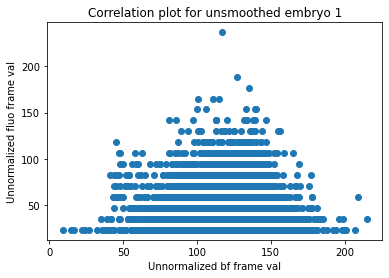

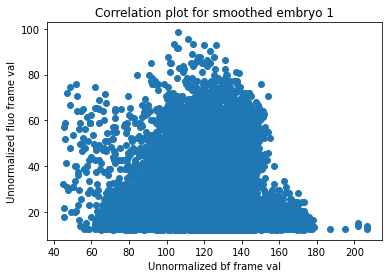

In [24]:
#%%
# correlation
# the indices of bf_images and fluo_images should be the same, and equal to embryo_idx
bf_fluo_correlate(embryo_idx, bf_images[1], fluo_images[1])
# bf_fluo_correlate(embryo_idx, bf_images[1], fluo_images[1], normalized=True)
bf_fluo_correlate(embryo_idx, bf_images[1], fluo_images[1], smoothed=True)

# bf_fluo_correlate_2d(embryo_idx, bf_images[1], fluo_images[1], smoothed=True)

In [28]:
def cross_correlation_coefficient(patch1, patch2):
    prod = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = np.std(patch1) * np.std(patch2)
    if stds == 0:
        return 0
    else:
        return prod / stds
    
def plot_cross_correlation(im1,im2,k=1):
    '''
    im1 and im2 are the two images to compare
    k is kernel size... we compare k x k squares to calculate their cross correlation
    '''
    # dimensions of the two images should be the same
    assert im1.shape == im2.shape
    dim_row, dim_col = im1.shape
    correlation_matrix = np.zeros_like(im1)

    # prob not the best way to show image...
    io.imshow(im1)
    io.show()
    io.imshow(im2)
    io.show()
    
    print("calculating cross-correlation matrix...")
    
    for i in range(k, dim_row - (k + 1)):
        for j in range(k, dim_col - (k + 1)):
            patch1 = im1[i - k: i + k + 1, j - k: j + k + 1]
            patch2 = im2[i - k: i + k + 1, j - k: j + k + 1]
            correlation_matrix[i, j] = cross_correlation_coefficient(patch1,patch2)

    io.imshow(correlation_matrix, cmap='gray')
    io.show()

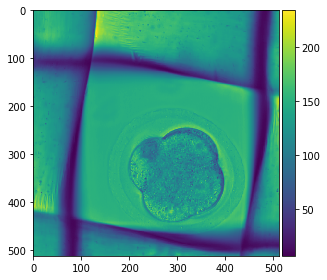

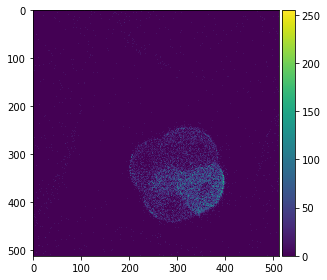

calculating cross-correlation matrix...


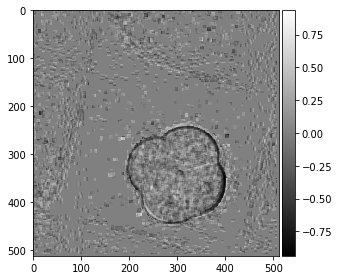

In [29]:
plot_cross_correlation(bf_images[1],fluo_images[1],k=3)